# Backpack Kaggle Competition
### W207 Final Project - Spring 2025

Team: Perry Gabriel, Aurelia Yang

University of California, Berkeley

## Description

In this competition, participants are challenged to develop machine learning models to predict the price of a backpack based on various features. This is a great opportunity to test your skills, learn new techniques, and compete with others in the data science community.

## Evaluation

Submissions are evaluated on the root mean squared error between the predicted and actual price of the backpack.

RMSE is defined as:
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

where $y_i$ is the actual price of the backpack and $\hat{y}_i$ is the predicted price of the backpack.

## Data Description

The data consists of the following columns:

- `id`: A unique identifier for the backpack.
- `Brand`: The brand of the backpack.
- `Material`: The material of the backpack.
- `Size`: The size of the backpack.
- `Compartments`: The number of compartments in the backpack.
- `Laptop Compartment`: Whether the backpack has a laptop compartment.
- `Waterproof`: Whether the backpack is waterproof.
- `Style`: The style of the backpack.
- `Color`: The color of the backpack.
- `Weight Capacity (kg)`: The weight capacity of the backpack in kilograms.
- `Price`: The price of the backpack.

## Data Splits
The dataset is split into three parts:
- **Train**: The training set contains 80% of the data and is used to train the model.
- **Validation**: The validation set contains 10% of the data and is used to tune the model.
- **Test**: The test set contains 10% of the data and is used to evaluate the model's performance.

## Important Notes about the Dataset
- There are (4) different datasets: train, train_extra, test, and sample_submission.
- The `train` dataset contains the training data with the target variable `Price`.
- The `train_extra` dataset contains additional training data that can be used to improve the model's performance.
- The `test` dataset contains the test data without the target variable `Price`.
- The `sample_submission` dataset contains a sample submission file with the correct format.
- The `train` and `train_extra` datasets are combined to create a larger training set.
- The `train_extra` dataset was provided by the competition organizers and is not part of the original dataset.

## Submission File

For each `id` in the test set, you must predict the price of the backpack. The file should contain a header and have the following format:

```python
id,Price
1,100
2,200
3,300
```

## Timeline

- **Start Date** - February 1, 2025
- **Entry Deadline** - Same as the Final Submission Deadline
- **Team Merger Deadline** - Same as the Final Submission Deadline
- **Final Submission Deadline** - February 28, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## Acknowledgements

This dataset was created by [Kaggle](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset) for the purpose of hosting a competition.

## Team Members

- [Perry Gabriel](https://www.kaggle.com/prgabriel)
- [Aurelia Yang](https://www.kaggle.com/aureliayang)

## Sections

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Modeling](#3.-Modeling)
4. [Evaluation](#4.-Evaluation)
5. [Optimization](#5.-Optimization)
6. [Final Submission](#6.-Final-Submission)
7. [Conclusion](#7.-Conclusion)

## References
[Backpack Kaggle Competition Link](https://www.kaggle.com/competitions/playground-series-s5e2)

[Backpack Kaggle Competition Dataset](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset)


## 0. Setup
Install the required libraries
Uncomment to download the data from Kaggle. This assumes you have the Kaggle API installed and configured.

In [4]:
# !kaggle competitions download -c playground-series-s5e2
# !unzip playground-series-s5e2 -d ../data/raw/
# !pip install -r ../requirements.txt
# !rm -rf playground-series-s5e2.zip

In [3]:
import os
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import mlflow.sklearn
import mlflow.xgboost
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

In [4]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_tracking_uri("azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw")
mlflow.set_experiment(experiment_name='E2E_Kaggle_Backpack_Project_Final')
mlflow.autolog()

2025/04/19 13:32:57 INFO mlflow.tracking.fluent: Experiment with name 'E2E_Kaggle_Backpack_Project_Final' does not exist. Creating a new experiment.
2025/04/19 13:32:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/19 13:32:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/04/19 13:32:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [5]:
raw_data_path = '../data/raw/'

In [6]:
def check_and_import_colab():
    global raw_data_path
    global processed_path
    try:
        from google.colab import drive  
        import google.colab
        print("Running on Google Colab")
        # Import necessary libraries for Google Colab
        drive.mount('/content/drive')

        # define paths
        raw_data_path = "/content/drive/MyDrive/Kaggle_Backpack/data/raw/"
        processed_path = "/content/drive/MyDrive/Kaggle_Backpack/data/processed/"
        return True

    except ImportError:
        print("Not running on Google Colab")
        os.makedirs(raw_data_path, exist_ok=True)
        print("Created 'raw_data_path' directory for non-Colab Environment.")
        return False

on_colab = check_and_import_colab()

if on_colab:
    print("Google Colab environment detected. Paths have been set accordingly.")
else:
    print("Local environment detected. Paths have been set accordingly.")

Not running on Google Colab
Created 'raw_data_path' directory for non-Colab Environment.
Local environment detected. Paths have been set accordingly.


## 1. Exploratory Data Analysis

In this section, we will explore the data to understand its structure and identify any patterns or trends that may be present.


### 1.1 Load the Data

Let's start by loading the data and taking a look at the first few rows.

In [7]:
train_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'train.csv'), index_col=0, header=0, sep=',')
test_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'test.csv'), index_col=0, header=0, sep=',')
train_extra_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'training_extra.csv'), index_col=0, header=0, sep=',')

train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [8]:
test_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [9]:
train_extra_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


### 1.2 Data Summary

Next, let's take a look at the summary statistics of the data.


In [10]:
# Display the summary statistics of the training data
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [11]:
test_df.describe()

,Compartments,Weight Capacity (kg)
count,200000.000000,199923.000000
mean,5.442855,17.993033
std,2.888740,6.972079
min,1.000000,5.000000
25%,3.000000,12.068875
50%,5.000000,18.054750
75%,8.000000,23.965700
max,10.000000,30.000000


In [12]:
train_extra_df.describe()

,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.692648e+06,3.694318e+06
mean,5.434022e+00,1.800883e+01,8.135820e+01
std,2.893227e+00,6.974541e+00,3.893050e+01
min,1.000000e+00,5.000000e+00,1.500000e+01
25%,3.000000e+00,1.206854e+01,4.747778e+01
50%,5.000000e+00,1.805243e+01,8.098592e+01
75%,8.000000e+00,2.398580e+01,1.148434e+02
max,1.000000e+01,3.000000e+01,1.500000e+02


Let's see the data types of each column.

In [13]:
print(f"Data types of columns in training dataset\n{train_df.dtypes}\n")
print(f"Data types of columns in training extra dataset\n{train_extra_df.dtypes}\n")
print(f"Data types of columns in testing dataset\n{test_df.dtypes}\n")

Data types of columns in training dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in training extra dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in testing dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style  

Let's get the shape of the data.

In [14]:
# Display the shape of the dataset.
print(f"Shape of training data: {train_df.shape}")
print(f"Shape of training extra data: {train_extra_df.shape}")
print(f"Shape of testing data: {test_df.shape}")

Shape of training data: (300000, 10)
Shape of training extra data: (3694318, 10)
Shape of testing data: (200000, 9)


#### Combine the train and train_extra datasets

Now, let's combine the train and train_extra datasets to create a larger training set.

In [15]:
# Combine train and train_extra datasets
train_df = pd.concat([train_df, train_extra_df], axis=0).reset_index(drop=True)

# Display the shape of the combined dataset
print(f"Shape of combined training data: {train_df.shape}")

# Display the shape of the combined dataset
train_df.shape

# Display the first few rows of the combined dataset
train_df.head()


Shape of combined training data: (3994318, 10)


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Let's capture the categories of the categorical variables.

In [16]:
cat_columns = train_df.columns[:-2].tolist()  # Dropped the last two columns since we know that these are numerical columns
print(f'There are {len(cat_columns)} categorical columns:')
print(cat_columns)

num_columns = [train_df.columns[-2]]
print(f'There are {len(num_columns)} numerical column:')
print(num_columns)

There are 8 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
There are 1 numerical column:
['Weight Capacity (kg)']


### 1.3 Data Visualization

We created visualizations to better understand the data.


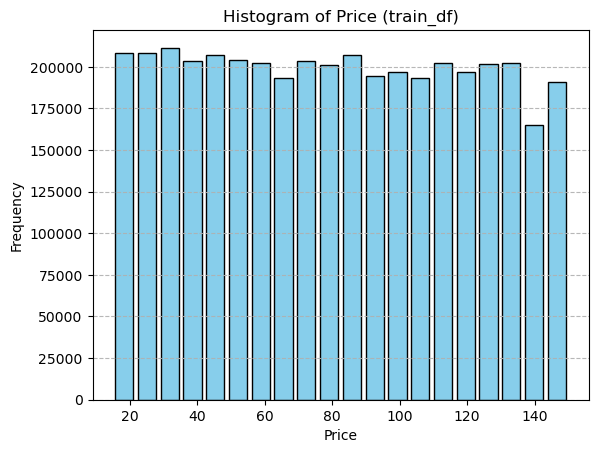

In [17]:
# For example, plot a histogram of the price column
plt.hist(train_df['Price'], bins=20, edgecolor='black', color='skyblue', rwidth=0.8)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (train_df)')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

### 1.4 Correlation Matrix

Finally, let's create a correlation matrix to see how the features are related to each other.


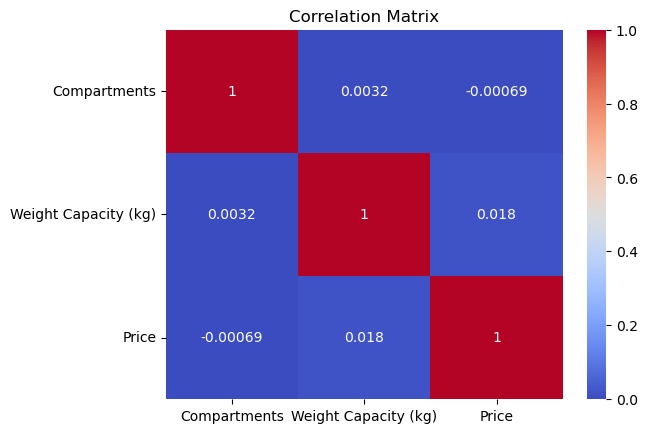

In [18]:
# Select only the numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
corr = numeric_cols.corr()

# Display the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Observations so far: 

- `training_extra` has significantly more records (3.69M) than `training` (300k), which will be useful in improving model training.
- Some categorical columns have substantial missing values:
    - `Brand`: 9705 missing in `train`, 117,000 missing in `train_extra`
    - `Material`, `Style`, `Color`
- `train_extra` has a higher proportion of missing values.
- Considering:
    - Mode imputation for categorical columns
    - Mean/median imputation for numerical columns


### 1.5 Feature Distribution

Let's take a look at the distribution of the features.

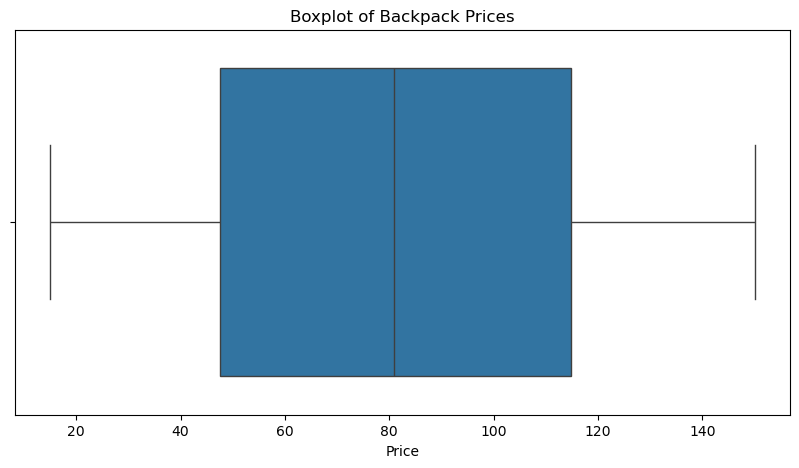

In [19]:
# outlier boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["Price"])
plt.title("Boxplot of Backpack Prices")
plt.show()

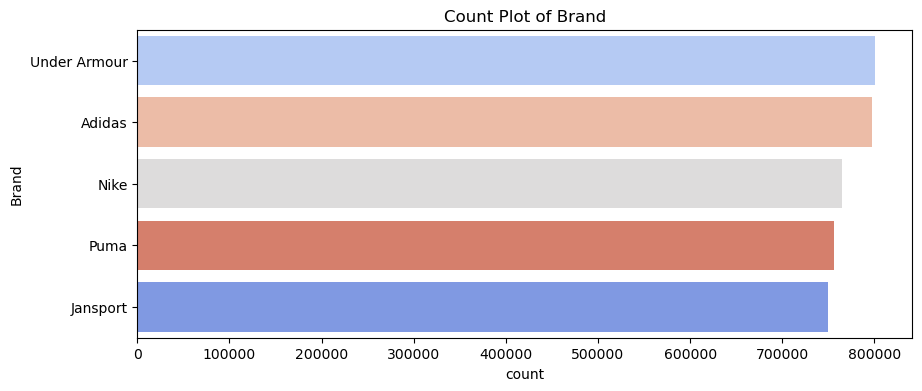

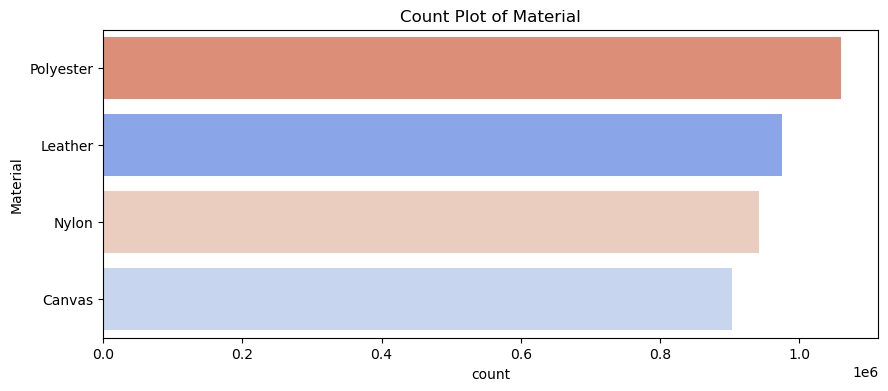

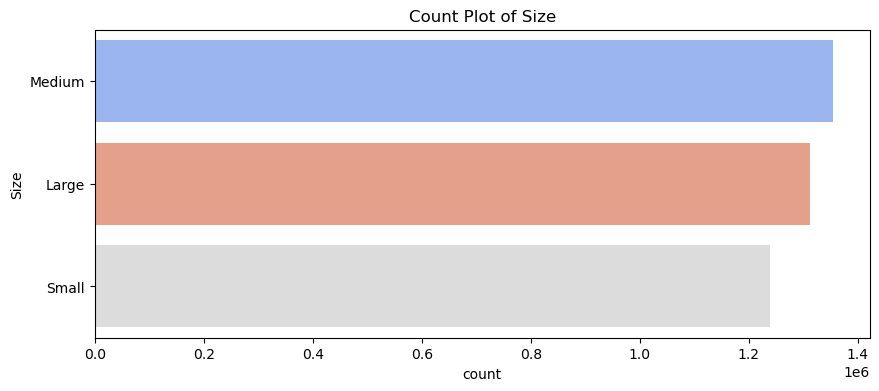

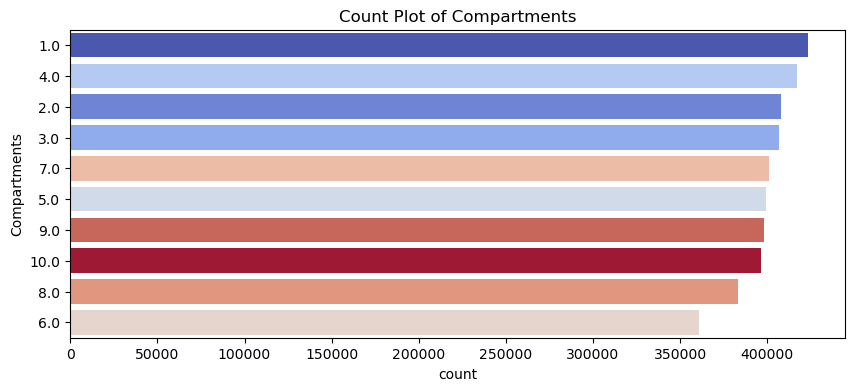

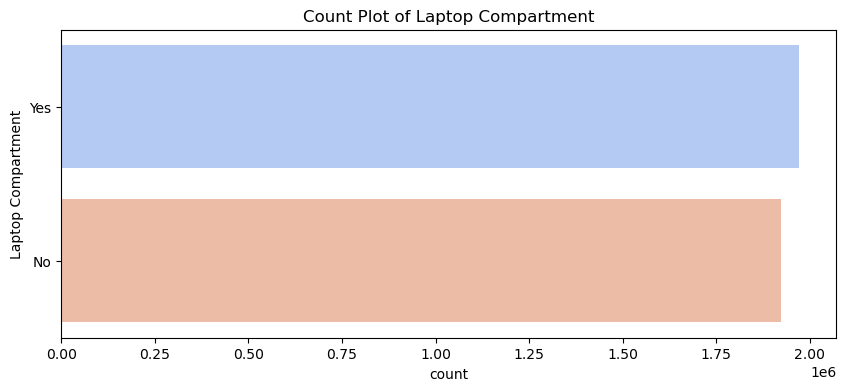

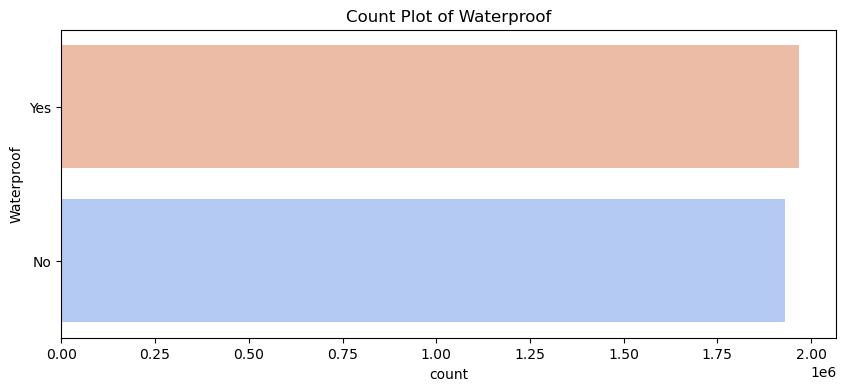

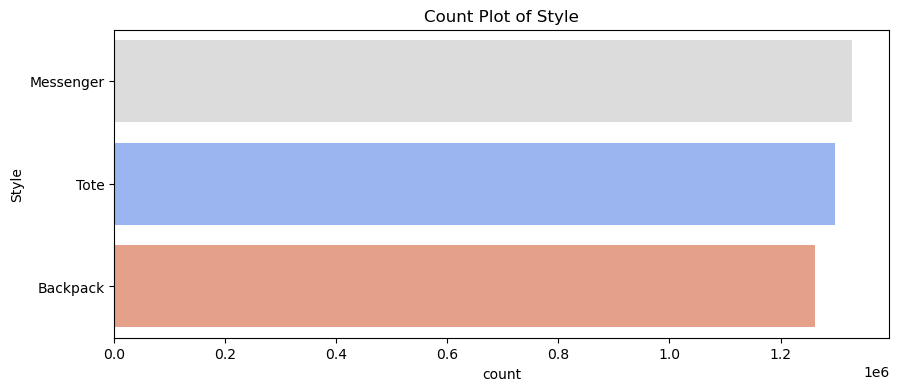

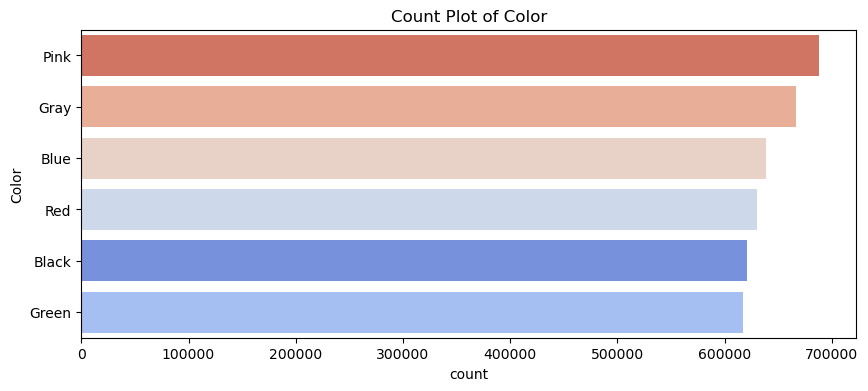

In [20]:
# categorical feature distribution
for col in cat_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="coolwarm", legend=False)
    plt.title(f"Count Plot of {col}")
    plt.show()


## 2. Data Preprocessing

In this section, we will preprocess the data to prepare it for modeling.

### 2.1 Feature Engineering

In this section, we will create new features that may help improve the performance of our models.


#### Creation of Combined (Combined_list) Features

For each original categorical column, a new feature is generated by combining it with `Weight Capacity`.

This is done to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack. The new feature is created by multiplying the weight capacity by 100 and adding it to the original categorical feature. This allows us to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack.

In [21]:
combined_list = []
label_encoders = {}

for c in cat_columns:  # Use 'cat_columns' as defined earlier in the notebook
    # Initialize and fit a LabelEncoder for the current column
    le = LabelEncoder()
    combined = pd.concat([train_df[c], test_df[c]], axis=0)
    le.fit(combined)
    label_encoders[c] = le  # Store the encoder for potential future use

    # Transform the train and test data
    train_df[c] = le.transform(train_df[c])
    test_df[c] = le.transform(test_df[c])

    # Create a new column combining the encoded value and weight capacity
    new_col = f"{c}_Weight_Capacity_Combined"
    train_df[new_col] = train_df[c] * 100 + train_df["Weight Capacity (kg)"]
    test_df[new_col] = test_df[c] * 100 + test_df["Weight Capacity (kg)"]

    # Append the new column name to the combined_list list
    combined_list.append(new_col)

print(f"We now have {len(combined_list)} new columns")
print(combined_list)

We now have 8 new columns
['Brand_Weight_Capacity_Combined', 'Material_Weight_Capacity_Combined', 'Size_Weight_Capacity_Combined', 'Compartments_Weight_Capacity_Combined', 'Laptop Compartment_Weight_Capacity_Combined', 'Waterproof_Weight_Capacity_Combined', 'Style_Weight_Capacity_Combined', 'Color_Weight_Capacity_Combined']


In [22]:
input_variables_le = cat_columns + num_columns + combined_list
print(f"We now have {len(input_variables_le)} columns:")
print(input_variables_le)

We now have 17 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Brand_Weight_Capacity_Combined', 'Material_Weight_Capacity_Combined', 'Size_Weight_Capacity_Combined', 'Compartments_Weight_Capacity_Combined', 'Laptop Compartment_Weight_Capacity_Combined', 'Waterproof_Weight_Capacity_Combined', 'Style_Weight_Capacity_Combined', 'Color_Weight_Capacity_Combined']


In [23]:
input_variables = cat_columns + num_columns
print(f"We now have {len(input_variables)} columns:")
print(input_variables)

We now have 9 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']


In [32]:
# Define the input features and target variable
X_le = train_df[input_variables_le]
y = train_df['Price']

# Split the data into training, validation, and test sets
X_train_le, X_temp_le, y_train_le, y_temp_le = train_test_split(X_le, y, test_size=0.3, random_state=42)
X_valid_le, X_test_le, y_valid_le, y_test_le = train_test_split(X_temp_le, y_temp_le, test_size=0.5, random_state=42)

# For the test dataset (test.csv), ensure it only contains the input features
X_test_final_le = test_df[input_variables_le]

# Display the shapes of the datasets
print(f"X_train_le shape: {X_train_le.shape}")
print(f"y_train_le shape: {y_train_le.shape}")
print(f"X_valid_le shape: {X_valid_le.shape}")
print(f"y_valid_le shape: {y_valid_le.shape}")
print(f"X_test_le shape: {X_test_le.shape}")
print(f"y_test_le shape: {y_test_le.shape}")
print(f"X_test_final_le shape: {X_test_final_le.shape}")

X_train_le shape: (2796022, 17)
y_train_le shape: (2796022,)
X_valid_le shape: (599148, 17)
y_valid_le shape: (599148,)
X_test_le shape: (599148, 17)
y_test_le shape: (599148,)
X_test_final_le shape: (200000, 17)


In [33]:
# Define the input features and target variable
X = train_df[input_variables]
y = train_df['Price']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# For the test dataset (test.csv), ensure it only contains the input features
X_test_final = test_df[input_variables]

# Display the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train shape: (2796022, 9)
y_train shape: (2796022,)
X_valid shape: (599148, 9)
y_valid shape: (599148,)
X_test shape: (599148, 9)
y_test shape: (599148,)
X_test_final shape: (200000, 9)


## 3. Modeling

In this section, we will select and train machine learning models to predict the price of the backpack.


In [26]:
# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_le, label=y_train_le)
dvalid = xgb.DMatrix(X_valid_le, label=y_valid_le)
dtest = xgb.DMatrix(X_test_le)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
evals = [(dtrain, 'train'), (dvalid, 'valid')]
le_xgb_model = xgb.train(params, dtrain, num_boost_round=1_000, evals=evals, early_stopping_rounds=50, verbose_eval=15)

# Make predictions on the validation set
le_y_pred_valid = le_xgb_model.predict(dvalid)

# Make predictions on the test set
le_y_pred_test = le_xgb_model.predict(dtest)

2025/04/19 13:37:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4ebc330b-38e7-4b66-9cd5-0407f4676612', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	train-rmse:38.94985	valid-rmse:38.89856
[15]	train-rmse:38.93311	valid-rmse:38.88332
[30]	train-rmse:38.92209	valid-rmse:38.87375
[45]	train-rmse:38.91371	valid-rmse:38.86668
[60]	train-rmse:38.90730	valid-rmse:38.86153
[75]	train-rmse:38.90191	valid-rmse:38.85747
[90]	train-rmse:38.89737	valid-rmse:38.85426
[105]	train-rmse:38.89342	valid-rmse:38.85187
[120]	train-rmse:38.88979	valid-rmse:38.84937
[135]	train-rmse:38.88646	valid-rmse:38.84758
[150]	train-rmse:38.88362	valid-rmse:38.84612
[165]	train-rmse:38.88096	valid-rmse:38.84485
[180]	train-rmse:38.87863	valid-rmse:38.84407
[195]	train-rmse:38.87626	valid-rmse:38.84296
[210]	train-rmse:38.87417	valid-rmse:38.84221
[225]	train-rmse:38.87220	valid-rmse:38.84146
[240]	train-rmse:38.87026	valid-rmse:38.84086
[255]	train-rmse:38.86838	valid-rmse:38.84023
[270]	train-rmse:38.86672	valid-rmse:38.83976
[285]	train-rmse:38.86497	valid-rmse:38.83927
[300]	train-rmse:38.86339	valid-rmse:38.83898
[315]	train-rmse:38.86179	valid-rmse:38.83

In [29]:
from sklearn.impute import SimpleImputer, KNNImputer

def evaluate_imputation_strategy(imputer, X_train, X_valid, y_train, y_valid):
    """
    Fits imputer on X_train, transforms X_valid,
    encodes categoricals, trains a linear regression,
    and returns validation MAE and RMSE.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_absolute_error, root_mean_squared_error
    from copy import deepcopy

    # deep copy
    X_train_copy = deepcopy(X_train)
    X_valid_copy = deepcopy(X_valid)

    # separate numeric and categorical columns
    numeric_cols = X_train_copy.select_dtypes(include=[np.number]).columns
    cat_cols = X_train_copy.select_dtypes(exclude=[np.number]).columns

    # 1. numeric imputation
    X_train_copy[numeric_cols] = imputer.fit_transform(X_train_copy[numeric_cols])
    X_valid_copy[numeric_cols] = imputer.transform(X_valid_copy[numeric_cols])

    # 2. fill categorical missing values
    X_train_copy[cat_cols] = X_train_copy[cat_cols].fillna("Missing")
    X_valid_copy[cat_cols] = X_valid_copy[cat_cols].fillna("Missing")

    # 3. one-hot encode categorical columns
    X_train_copy = pd.get_dummies(X_train_copy, columns=cat_cols)
    X_valid_copy = pd.get_dummies(X_valid_copy, columns=cat_cols)

    # 4. align columns (to match dummy columns between sets)
    X_train_copy, X_valid_copy = X_train_copy.align(X_valid_copy, join='left', axis=1)
    X_valid_copy = X_valid_copy.fillna(0)

    # 5. train and evaluate
    model = LinearRegression()
    model.fit(X_train_copy, y_train)
    y_pred = model.predict(X_valid_copy)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = root_mean_squared_error(y_valid, y_pred)

    return mae, rmse

# Disable MLflow autologging temporarily to avoid logging the dataset
mlflow.autolog(disable=True)

simple_median_imputer = SimpleImputer(strategy='median')
mae_median, rmse_median = evaluate_imputation_strategy(simple_median_imputer, X_train, X_valid, y_train, y_valid)

knn_imputer = KNNImputer(n_neighbors=5)
mae_knn, rmse_knn = evaluate_imputation_strategy(knn_imputer, X_train, X_valid, y_train, y_valid)

print("MAE with Median Imputer:", mae_median)
print("RMSE with Median Imputer:", rmse_median)
print("MAE with KNN Imputer:", mae_knn)
print("RMSE with KNN Imputer:", rmse_knn)

# Re-enable MLflow autologging
mlflow.autolog()

MAE with Median Imputer: 33.637268290644926
RMSE with Median Imputer: 38.890545181844836
MAE with KNN Imputer: 33.63727166664187
RMSE with KNN Imputer: 38.89055704408697


In [30]:
# Handle missing values by filling them with the median
X_train_le = X_train_le.fillna(X_train_le.median())
X_valid_le = X_valid_le.fillna(X_valid_le.median())
X_test_le = X_test_le.fillna(X_test_le.median())

# Train the Linear Regression model
le_lr_model = LinearRegression()
le_lr_model.fit(X_train_le, y_train_le)

# Make predictions on the validation set
le_y_pred_lr = le_lr_model.predict(X_valid_le)

# Make predictions on the test set
le_y_pred_test_lr = le_lr_model.predict(X_test_le)

# Display the first few predictions
print("First few predictions on the test set:", le_y_pred_test_lr[:5])

2025/04/19 13:48:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '048ca1c9-4af4-4521-ac4f-3b48b0bd715f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/19 13:49:30 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': 'a1e29da46f09a0c8d6641af91219417d', 'request': '72e879348f8bbb8f'}, 'Environment': 'eastus', 'Location': 'eastus', 'Time': '2025-04-19T13:49:30.31068+00:00', 'ComponentName': 'mlflow', 'statusCode': 400, 'error_code': 'BAD_REQUEST'}


🏃 View run nifty_tray_rwsyxksn at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/048ca1c9-4af4-4521-ac4f-3b48b0bd715f
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
First few predictions on the test set: [81.37837347 80.10693897 81.68864735 81.4905089  83.26703819]


In [31]:
# Count missing cells in numeric columns
missing_counts = X_train.select_dtypes(include=[np.number]).isna().sum()
print(missing_counts[missing_counts > 0])

Weight Capacity (kg)    1285
dtype: int64


They both have the same MAE and RMSE, so we will go ahead with the median approach, as it is simpler and faster at scale.

In [34]:
# Separate numeric vs. categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Fill numeric columns with X_train's median
numeric_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = numeric_imputer.transform(X_valid[numeric_cols])
X_test[numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

# Fill categorical columns with "Missing"
X_train[cat_cols] = X_train[cat_cols].fillna("Missing")
X_valid[cat_cols] = X_valid[cat_cols].fillna("Missing")
X_test[cat_cols] = X_test[cat_cols].fillna("Missing")

Now we will standardize numeric features.

In [ ]:
# numeric standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit on X_train numeric features
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

And perform one-hot encoding on the categorical variables.

In [ ]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

# instantiate the encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# fit on train's categorical columns
ohe.fit(X_train[cat_cols])

# transform each dataset's categorical columns
X_train_ohe = ohe.transform(X_train[cat_cols])
X_valid_ohe = ohe.transform(X_valid[cat_cols])
X_test_ohe  = ohe.transform(X_test[cat_cols])

# convert numeric columns to arrays
X_train_numeric = X_train[numeric_cols].values
X_valid_numeric = X_valid[numeric_cols].values
X_test_numeric  = X_test[numeric_cols].values

# concatenate numeric and encoded categorical data
X_train_final = np.concatenate([X_train_numeric, X_train_ohe], axis=1)
X_valid_final = np.concatenate([X_valid_numeric, X_valid_ohe], axis=1)
X_test_final_2 = np.concatenate([X_test_numeric, X_test_ohe], axis=1)

**IMPORTANT NOTE TO SELF:**
Make the same changes for XGBoost as well, or any other model you train. For example:

xgb_regressor.fit(X_train_final, y_train, eval_set=[(X_train_final, y_train), (X_valid_final, y_valid)], verbose=15)
...
y_pred_test_xgb = xgb_regressor.predict(X_test_final_2)

Otherwise, we'll be mixing data that’s not one-hot-encoded for XGBoost.

Linear Regression Model

In [37]:
# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_valid_final)

# Make predictions on the test set
y_pred_test_lr = lr_model.predict(X_test_final_2)

# Display the first few predictions
print("First few predictions on the test set:", y_pred_test_lr[:5])

2025/04/19 13:58:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '003cc2f1-8bb6-4caf-bb5a-d39690638b2b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/19 13:58:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run icy_box_cfwbc8d9 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/003cc2f1-8bb6-4caf-bb5a-d39690638b2b
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
First few predictions on the test set: [81.37843422 80.09687816 81.69168058 81.47179457 83.24804196]


XGBoost model

In [38]:
# Convert the one-hot encoded data into DMatrix format
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dvalid = xgb.DMatrix(X_valid_final, label=y_valid)
dtest = xgb.DMatrix(X_test_final_2)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
evals = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=15
)

# Make predictions
y_pred_valid = xgb_model.predict(dvalid)
y_pred_test = xgb_model.predict(dtest)

print("First few predictions on the test set:", y_pred_test[:5])

2025/04/19 13:58:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '676b0bb8-3c5e-4460-bc09-b946d45a2bdd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	train-rmse:38.94987	valid-rmse:38.89853
[15]	train-rmse:38.93520	valid-rmse:38.88501
[30]	train-rmse:38.92477	valid-rmse:38.87562
[45]	train-rmse:38.91752	valid-rmse:38.86933
[60]	train-rmse:38.91173	valid-rmse:38.86457
[75]	train-rmse:38.90716	valid-rmse:38.86086
[90]	train-rmse:38.90300	valid-rmse:38.85761
[105]	train-rmse:38.89952	valid-rmse:38.85515
[120]	train-rmse:38.89616	valid-rmse:38.85274
[135]	train-rmse:38.89329	valid-rmse:38.85087
[150]	train-rmse:38.89072	valid-rmse:38.84933
[165]	train-rmse:38.88857	valid-rmse:38.84820
[180]	train-rmse:38.88651	valid-rmse:38.84716
[195]	train-rmse:38.88466	valid-rmse:38.84619
[210]	train-rmse:38.88284	valid-rmse:38.84532
[225]	train-rmse:38.88116	valid-rmse:38.84448
[240]	train-rmse:38.87966	valid-rmse:38.84389
[255]	train-rmse:38.87804	valid-rmse:38.84306
[270]	train-rmse:38.87663	valid-rmse:38.84266
[285]	train-rmse:38.87526	valid-rmse:38.84219
[300]	train-rmse:38.87392	valid-rmse:38.84175
[315]	train-rmse:38.87268	valid-rmse:38.84

XGBRegressor model

In [39]:
# Initialize the XGBRegressor model
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Train the model on the training dataset
xgb_regressor.fit(
    X_train_final,
    y_train,
    eval_set=[(X_train_final, y_train), (X_valid_final, y_valid)],
    verbose=15
)

# Make predictions on the validation set
y_pred_valid_xgb = xgb_regressor.predict(X_valid_final)

# Make predictions on the test set
y_pred_test_xgb = xgb_regressor.predict(X_test_final_2)

# Display the first few predictions
print("First few predictions on the test set:", y_pred_test_xgb[:5])

2025/04/19 14:00:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e7ee4c32-7b00-4279-9231-9b575db5373c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/19 14:00:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpfjf7qwjz/model, flavor: xgboost). Fall back to return ['xgboost==2.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/19 14:00:44 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operati

[0]	validation_0-rmse:38.94987	validation_1-rmse:38.89853
[15]	validation_0-rmse:38.93520	validation_1-rmse:38.88501
[30]	validation_0-rmse:38.92477	validation_1-rmse:38.87562
[45]	validation_0-rmse:38.91752	validation_1-rmse:38.86933
[60]	validation_0-rmse:38.91173	validation_1-rmse:38.86457
[75]	validation_0-rmse:38.90716	validation_1-rmse:38.86086
[90]	validation_0-rmse:38.90300	validation_1-rmse:38.85761
[99]	validation_0-rmse:38.90086	validation_1-rmse:38.85607
🏃 View run dreamy_thread_vgwsqg65 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/e7ee4c32-7b00-4279-9231-9b575db5373c
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azur

Random Forest Regressor model

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


rf_model = RandomForestRegressor(
    n_estimators=30,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='log2',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_final, y_train)

#predictions
y_pred_valid_rf = rf_model.predict(X_valid_final)
y_pred_test_rf  = rf_model.predict(X_test_final_2)

# evaluate
rf_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_rf))
print(f"Random Forest Validation RMSE: {rf_rmse_valid:.3f}")


2025/04/19 14:00:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '10ddc9cb-8815-4ba9-827d-b42518dbba74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/19 14:00:44 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/04/19 14:00:57 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: INVALID_PARAMETER_VALUE: Response: {'Error': {'Code': 'ValidationError', 'Severity': None, 'Message': 'A given key of Inputs can not modify its value after it is set', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': '0fe9334e0ed06d458ed5075b7d2e26e7', 'request': 'abea03263eb65c53'}, 'Enviro

🏃 View run lemon_stamp_12ntqtrg at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/10ddc9cb-8815-4ba9-827d-b42518dbba74
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
Random Forest Validation RMSE: 38.848


In [41]:
# increase n estimators and depth
rf_model2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=14,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='log2',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf_model2.fit(X_train_final, y_train)

#predictions
y_pred_valid_rf = rf_model2.predict(X_valid_final)
y_pred_test_rf  = rf_model2.predict(X_test_final_2)

# evaluate
rf_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_rf))
print(f"Random Forest Validation RMSE: {rf_rmse_valid:.3f}")

2025/04/19 14:00:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b45fd8f-e736-402e-ac30-92740d64b1a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/04/19 14:00:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/04/19 14:01:29 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: INVALID_PARAMETER_VALUE: Response: {'Error': {'Code': 'ValidationError', 'Severity': None, 'Message': 'A given key of Inputs can not modify its value after it is set', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operation': 'e3b3620e45be700688043a9626ef5915', 'request': 'f77d8fd1bfb9667e'}, 'Enviro

🏃 View run brave_evening_6nkspgmx at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/0b45fd8f-e736-402e-ac30-92740d64b1a7
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
Random Forest Validation RMSE: 38.843


Marginal improvement in RMSE with more estimators and higher depth. There is no meaningful gain.

In [42]:
import tensorflow as tf
from tensorflow import keras

# Ensure a GPU is available (Runtime ▸ Change runtime type ▸ GPU)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

INPUT_DIM = X_train_final.shape[1]

# ── Build the network ─────────────────────────────────────────
def make_model(input_dim):
    return keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(1)   # linear output for regression
    ])

model = make_model(INPUT_DIM)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

# ── Train ─────────────────────────────────────────────────────
EPOCHS      = 20
BATCH_SIZE  = 1024   # fits easily in GPU memory
early_stop  = keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, monitor='val_rmse'
)

history = model.fit(
    X_train_final, y_train,
    validation_data=(X_valid_final, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=2
)

# ── Evaluate ──────────────────────────────────────────────────
y_pred_nn = model.predict(X_valid_final, batch_size=4096).squeeze()
nn_rmse   = np.sqrt(mean_squared_error(y_valid, y_pred_nn))
print(f"Neural‑Net Validation RMSE: {nn_rmse:.3f}")

# ── Predict test if desired ──────────────────────────────────
y_pred_test_nn = model.predict(X_test_final_2, batch_size=4096).squeeze()


2025-04-19 14:01:30.207655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 14:01:30.220028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745071290.232754   89547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745071290.236565   89547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745071290.246678   89547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU available: []


Epoch 1/20
2731/2731 - 16s - 6ms/step - loss: 2256.9326 - rmse: 47.5072 - val_loss: 1513.6719 - val_rmse: 38.9059
Epoch 2/20
2731/2731 - 14s - 5ms/step - loss: 1534.1191 - rmse: 39.1678 - val_loss: 1512.2179 - val_rmse: 38.8872
Epoch 3/20
2731/2731 - 14s - 5ms/step - loss: 1530.1445 - rmse: 39.1171 - val_loss: 1511.7683 - val_rmse: 38.8815
Epoch 4/20
2731/2731 - 14s - 5ms/step - loss: 1528.5215 - rmse: 39.0963 - val_loss: 1511.4230 - val_rmse: 38.8770
Epoch 5/20
2731/2731 - 14s - 5ms/step - loss: 1528.2085 - rmse: 39.0923 - val_loss: 1511.2738 - val_rmse: 38.8751
Epoch 6/20
2731/2731 - 14s - 5ms/step - loss: 1527.9214 - rmse: 39.0886 - val_loss: 1511.2567 - val_rmse: 38.8749
Epoch 7/20
2731/2731 - 14s - 5ms/step - loss: 1527.5795 - rmse: 39.0843 - val_loss: 1511.3381 - val_rmse: 38.8759
Epoch 8/20
2731/2731 - 14s - 5ms/step - loss: 1527.3098 - rmse: 39.0808 - val_loss: 1511.2518 - val_rmse: 38.8748
Epoch 9/20
2731/2731 - 14s - 5ms/step - loss: 1527.1309 - rmse: 39.0785 - val_loss: 1510

In [43]:
# Initialize the XGBRegressor model
le_xgb_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50, 
    random_state=42
)

# Train the model on the training dataset
le_xgb_regressor.fit(
    X_train_le, 
    y_train_le, 
    eval_set=[(X_train_le, y_train_le), (X_valid_le, y_valid_le)], 
    verbose=15
)

# Make predictions on the validation set
le_y_pred_valid_xgb = le_xgb_regressor.predict(X_valid_le)

# Make predictions on the test set
le_y_pred_test_xgb = le_xgb_regressor.predict(X_test_le)

# Display the first few predictions
print("First few predictions on the test set:", le_y_pred_test_xgb[:5])

2025/04/19 14:05:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dedd6766-356d-472a-87ad-7bbc8e87d64c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/04/19 14:06:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvlv9hfv_/model, flavor: xgboost). Fall back to return ['xgboost==2.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/19 14:06:12 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: BAD_REQUEST: Response: {'Error': {'Code': 'UserError', 'Severity': None, 'Message': 'Cannot log the same dataset with different context', 'MessageFormat': None, 'MessageParameters': None, 'ReferenceCode': None, 'DetailsUri': None, 'Target': None, 'Details': [], 'InnerError': None, 'DebugInfo': None, 'AdditionalInfo': None}, 'Correlation': {'operati

[0]	validation_0-rmse:38.94985	validation_1-rmse:38.89856
[15]	validation_0-rmse:38.93311	validation_1-rmse:38.88332
[30]	validation_0-rmse:38.92209	validation_1-rmse:38.87375
[45]	validation_0-rmse:38.91371	validation_1-rmse:38.86668
[60]	validation_0-rmse:38.90730	validation_1-rmse:38.86153
[75]	validation_0-rmse:38.90191	validation_1-rmse:38.85747
[90]	validation_0-rmse:38.89737	validation_1-rmse:38.85426
[99]	validation_0-rmse:38.89497	validation_1-rmse:38.85272
🏃 View run elated_date_1tdhdvnb at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/dedd6766-356d-472a-87ad-7bbc8e87d64c
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azurem

## 4. Evaluation

In this section, we will evaluate the performance of our models using various metrics.


In [44]:
# Evaluate the xgb model using RMSE
xgb_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
print(f"Baseline - XGBoost Validation RMSE: {xgb_rmse_valid}")

# Calculate RMSE for the validation set
xgbreg_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_xgb))
print(f"Baseline - XGBoost Regressor Validation RMSE: {xgbreg_rmse_valid}")

# Evaluate the linear regression model using RMSE
rmse_lr = np.sqrt(mean_squared_error(y_valid, y_pred_lr))
print(f"Baseline - Linear Regression Validation RMSE: {rmse_lr}")

# Evaluate the random forest model using RMSE
rf_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid_rf))
print(f"Baseline - Random Forest Validation RMSE: {rf_rmse_valid}")

# Evaluate the neural network model using RMSE
nn_rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_nn))
print(f"Baseline - Neural Network Validation RMSE: {nn_rmse_valid}")

# Evaluate the LE xgb model using RMSE
le_xgb_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, le_y_pred_valid))
print(f"Baseline - LE XGBoost Validation RMSE: {le_xgb_rmse_valid}")

# Calculate RMSE for the LE xgb regressor validation set
le_xgbreg_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, le_y_pred_valid_xgb))
print(f"Baseline - LE XGBoost Regressor Validation RMSE: {le_xgbreg_rmse_valid}")

# Evaluate the LE linear regression model using RMSE
le_rmse_lr = np.sqrt(mean_squared_error(y_valid_le, le_y_pred_lr))
print(f"Baseline - LE Linear Regression Validation RMSE: {le_rmse_lr}")

Baseline - XGBoost Validation RMSE: 38.83565164966077
Baseline - XGBoost Regressor Validation RMSE: 38.856067148720605
Baseline - Linear Regression Validation RMSE: 38.890545181844836
Baseline - Random Forest Validation RMSE: 38.8431194593009
Baseline - Neural Network Validation RMSE: 38.86741939840839
Baseline - LE XGBoost Validation RMSE: 38.83358212137811
Baseline - LE XGBoost Regressor Validation RMSE: 38.85272280530174
Baseline - LE Linear Regression Validation RMSE: 38.88934990411435


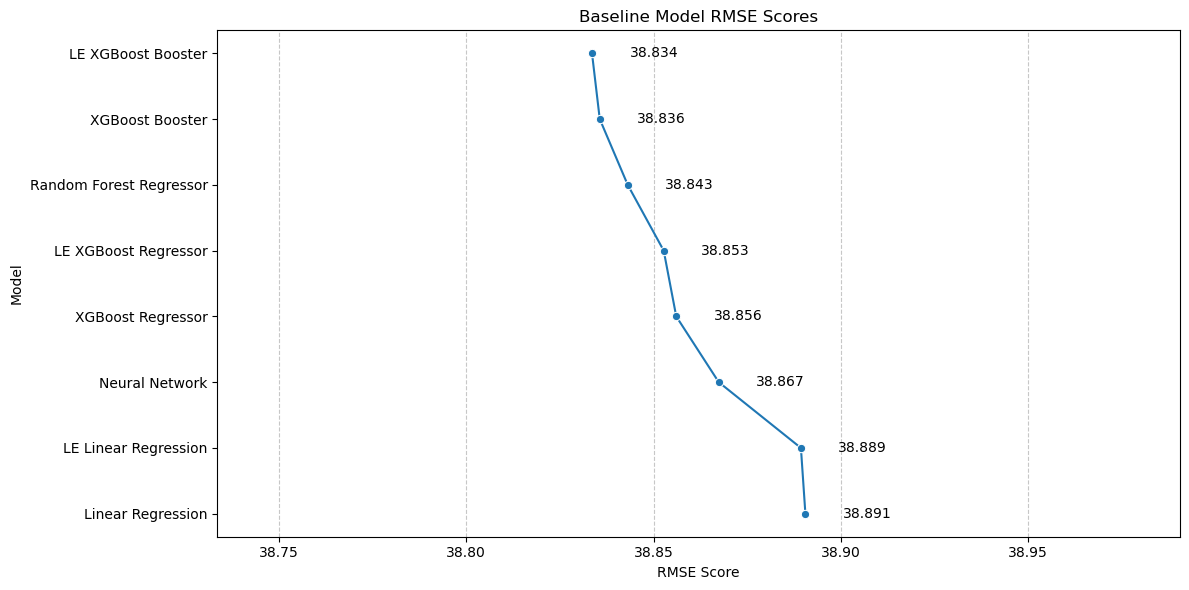

In [86]:
# Create a dictionary of model names and their RMSE scores
baseline_rmse_scores = {
    "LE XGBoost Booster": le_xgb_rmse_valid,
    "LE XGBoost Regressor": le_xgbreg_rmse_valid,
    "LE Linear Regression": le_rmse_lr,
    "XGBoost Booster": xgb_rmse_valid,
    "XGBoost Regressor": xgbreg_rmse_valid,
    "Linear Regression": rmse_lr,
    "Random Forest Regressor": rf_rmse_valid,
    "Neural Network": nn_rmse_valid
}

# Sort the models by RMSE scores
sorted_baseline_rmse = dict(sorted(baseline_rmse_scores.items(), key=lambda item: item[1]))

# Convert the sorted dictionary to a DataFrame for Seaborn
baseline_rmse_df = pd.DataFrame(list(sorted_baseline_rmse.items()), columns=['Model', 'RMSE'])

# Plot the RMSE scores with a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=baseline_rmse_df, x='RMSE', y='Model', marker='o', palette='viridis')

# Add annotations for each RMSE value
for index, row in baseline_rmse_df.iterrows():
    plt.text(row['RMSE'] + 0.01, row['Model'], f"{row['RMSE']:.3f}", va='center', ha='left', fontsize=10, color='black')

plt.xlabel('RMSE Score')
plt.ylabel('Model')
plt.title('Baseline Model RMSE Scores')

# Zoom in on the RMSE range
plt.xlim(baseline_rmse_df['RMSE'].min() - 0.1, baseline_rmse_df['RMSE'].max() + 0.1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [45]:
import mlflow.sklearn
import mlflow.xgboost
import mlflow.tensorflow

# Log the XGBoost Booster model
mlflow.xgboost.log_model(le_xgb_model, artifact_path="le_xgb_booster_model", registered_model_name="le_xgb_booster_model")

# Log the XGBoost Regressor model
mlflow.sklearn.log_model(le_xgb_regressor, artifact_path="le_xgb_regressor_model", registered_model_name="le_xgb_regressor_model")

# Log the Linear Regression model (Label Encoded)
mlflow.sklearn.log_model(le_lr_model, artifact_path="le_linear_regression_model", registered_model_name="le_linear_regression_model")

# Log the XGBoost Booster model (One-Hot Encoded)
mlflow.xgboost.log_model(xgb_model, artifact_path="xgb_booster_model", registered_model_name="xgb_booster_model")

# Log the XGBoost Regressor model (One-Hot Encoded)
mlflow.sklearn.log_model(xgb_regressor, artifact_path="xgb_regressor_model", registered_model_name="xgb_regressor_model")

# Log the Linear Regression model (One-Hot Encoded)
mlflow.sklearn.log_model(lr_model, artifact_path="linear_regression_model", registered_model_name="linear_regression_model")

# Log the Random Forest model
mlflow.sklearn.log_model(rf_model, artifact_path="random_forest_model", registered_model_name="random_forest_model")

# Log the Random Forest model with increased depth and estimators
mlflow.sklearn.log_model(rf_model2, artifact_path="random_forest_model_v2", registered_model_name="random_forest_model_v2")

# Log the Neural Network model
mlflow.tensorflow.log_model(model, artifact_path="neural_network_model", registered_model_name="neural_network_model")

print("All models logged successfully as MLflow models.")


2025/04/19 14:11:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'le_xgb_booster_model'.
2025/04/19 14:11:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: le_xgb_booster_model, version 1
Created version '1' of model 'le_xgb_booster_model'.
2025/04/19 14:11:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'le_xgb_regressor_model'.
2025/04/19 14:11:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: le_xgb_regressor_model, version 1
Created version '1' of model 'le_xgb_regressor_model'.
2025/04/19 14:11:37 WARNING mlflow

In [49]:
mlflow.end_run()

🏃 View run amiable_hat_j3vvc7m9 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/2f3d0f54-d123-4fe0-bb0c-0ad735d67327
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f




## 5. Model Optimization

In this section, we will optimize the hyperparameters of our models to improve their performance.


The next cell performs hyperparameter tuning for an ElasticNet regression model using `GridSearchCV`. It defines a parameter grid for `alpha` and `l1_ratio`, trains the model on the training dataset (`X_train_le` and `y_train_le`), and evaluates it on the validation dataset (`X_valid_le` and `y_valid_le`). The best parameters and validation RMSE are logged using MLflow, and the trained model is saved. Finally, predictions are made on the test dataset (`X_test_le`).

In [51]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import mlflow.sklearn

# Start an MLflow run
with mlflow.start_run(run_name="ElasticNet Hyperparameter Tuning"):
    # Handle missing values by filling them with the median
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train_le = imputer.fit_transform(X_train_le)
    X_valid_le = imputer.transform(X_valid_le)
    X_test_le = imputer.transform(X_test_le)

    # Define the parameter grid for ElasticNet
    elasticnet_param_grid = {
        'alpha': [0.01, 0.05, 0.1, 0.5, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    # Initialize the ElasticNet model
    elasticnet_model = ElasticNet()

    # Perform GridSearchCV to find the best hyperparameters
    grid_search_en = GridSearchCV(estimator=elasticnet_model, param_grid=elasticnet_param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
    grid_search_en.fit(X_train_le, y_train_le)

    # Get the best model and parameters
    elasticnet_model = grid_search_en.best_estimator_
    best_params_en = grid_search_en.best_params_
    print(f"Best Parameters for ElasticNet: {best_params_en}")

    # Log the best parameters
    mlflow.log_params(best_params_en)

    # Train the model on the training dataset
    elasticnet_model.fit(X_train_le, y_train_le)

    # Make predictions on the validation set
    y_pred_valid_en = elasticnet_model.predict(X_valid_le)

    # Evaluate the model using RMSE
    en_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, y_pred_valid_en))
    print(f"ElasticNet Validation RMSE: {en_rmse_valid}")

    # Log the RMSE metric
    mlflow.log_metric("Validation RMSE", en_rmse_valid)

    # Make predictions on the test set
    y_pred_test_en = elasticnet_model.predict(X_test_le)

    # Log the ElasticNet model
    mlflow.sklearn.log_model(elasticnet_model, artifact_path="le_elasticnet_model", registered_model_name="le_elasticnet_model")

    # Display the first few predictions
    print("First few predictions on the test set:", y_pred_test_en[:5])

print("ElasticNet model training and tracking completed.")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
🏃 View run affable_queen_fb3s3ck6 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/a18bf3c0-89b2-47ec-a449-e35e4ae06cdb
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
🏃 View run sweet_rice_8v98kd25 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/ff45b4ed-74f2-4927-ad8e-15086560b340
🧪 View experiment at: https://e

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e+07, tolerance: 2.827e+05
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.132e+07, tolerance: 2.828e+05
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

The next cell performs hyperparameter tuning for a `GradientBoostingRegressor` model using `GridSearchCV`.


In [53]:
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GradientBoostingRegressor
param_grid = {
    'learning_rate': [0.04, 0.045],
    'n_estimators': [50],
    'max_depth': [6],
    'min_samples_split': [0.00075],
    'min_samples_leaf': [0.0074],
    'subsample': [0.6],
    'max_features': [0.15],
    'loss': ['huber'],
    'criterion': ['squared_error']
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor()

# Start an MLflow run
with mlflow.start_run(run_name="GradientBoostingRegressor Hyperparameter Tuning"):
    # Perform GridSearchCV to find the best hyperparameters
    grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
    grid_search_gbr.fit(X_train_le, y_train_le)

    # Get the best model and parameters
    gbr_model = grid_search_gbr.best_estimator_
    best_params_gbr = grid_search_gbr.best_params_
    print(f"Best Parameters for GradientBoostingRegressor: {best_params_gbr}")

    # Log the best parameters
    mlflow.log_params(best_params_gbr)

    # Make predictions on the validation set
    y_pred_valid_gbr = gbr_model.predict(X_valid_le)

    # Evaluate the model using RMSE
    gbr_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, y_pred_valid_gbr))
    print(f"GradientBoostingRegressor Validation RMSE: {gbr_rmse_valid}")

    # Log the RMSE metric
    mlflow.log_metric("Validation RMSE", gbr_rmse_valid)

    # Log the GradientBoostingRegressor model
    mlflow.sklearn.log_model(gbr_model, artifact_path="le_gradient_boosting_model", registered_model_name="le_gradient_boosting_model")

    # Make predictions on the test set
    y_pred_test_gbr = gbr_model.predict(X_test_le)

print("GradientBoostingRegressor model training and tracking completed.")

2025/04/19 14:44:02 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/04/19 14:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'le_gradient_boosting_model' already exists. Creating a new version of this model...
2025/04/19 14:46:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: le_gradient_boosting_model, version 2


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters for GradientBoostingRegressor: {'criterion': 'squared_error', 'learning_rate': 0.045, 'loss': 'huber', 'max_depth': 6, 'max_features': 0.15, 'min_samples_leaf': 0.0074, 'min_samples_split': 0.00075, 'n_estimators': 50, 'subsample': 0.6}
GradientBoostingRegressor Validation RMSE: 38.87197004704999
🏃 View run GradientBoostingRegressor Hyperparameter Tuning at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/b94859ca-702a-4e5b-8f28-bcbc1466120b
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f
GradientBoosti

The next cell performs hyperparameter tuning for a `LightGBM` model using `GridSearchCV`.

In [55]:
import lightgbm as lgb
import mlflow.lightgbm

# Define the parameter grid for LightGBM
param_grid = {
    'num_leaves': [3],
    'max_depth': [5, 10],
    'learning_rate': [0.08],
    'n_estimators': [200],
    'subsample': [0.65],
    'colsample_bytree': [1.0]
}

# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_le, y_train_le)

# Get the best model and parameters
best_lgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Start an MLflow run
with mlflow.start_run(run_name="LightGBM Hyperparameter Tuning"):
    # Log the best parameters
    mlflow.log_params(best_params)

    # Make predictions on the validation set
    y_pred_valid_lgb = best_lgb_model.predict(X_valid_le)

    # Evaluate the model using RMSE
    lgb_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, y_pred_valid_lgb))
    print(f"LightGBM Validation RMSE: {lgb_rmse_valid}")

    # Log the RMSE metric
    mlflow.log_metric("Validation RMSE", lgb_rmse_valid)

    # Log the LightGBM model
    mlflow.lightgbm.log_model(best_lgb_model, artifact_path="le_lightgbm_model", registered_model_name="le_lightgbm_model")

    # Make predictions on the test set
    y_pred_test_lgb = best_lgb_model.predict(X_test_le)

print("LightGBM model training and tracking completed.")

2025/04/19 14:54:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '06a20fa8-1792-4fdf-82a9-5f84f203efc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025/04/19 14:55:59 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 2796022, number of used features: 17
[LightGBM] [Info] Start training from score 81.362346
🏃 View run neat_tongue_vcfjp3ll at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/06a20fa8-1792-4fdf-82a9-5f84f203efc8
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-m

The next cell performs hyperparameter tuning for a `GradientBoostingRegressor` model using `GridSearchCV`.


In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import mlflow.sklearn

# Define the parameter grid for GradientBoostingRegressor
param_grid = {
    'learning_rate': [0.04, 0.045],
    'n_estimators': [50],
    'max_depth': [6],
    'min_samples_split': [0.00075],
    'min_samples_leaf': [0.0074],
    'subsample': [0.6],
    'max_features': [0.1],
    'loss': ['huber'],
    'criterion': ['squared_error']
}

# Perform GridSearchCV to find the best hyperparameters
grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_log_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV on the training data
grid_search_gbr.fit(X_train_le, y_train_le)

# Get the best model and parameters
gbr_model = grid_search_gbr.best_estimator_
best_params_gbr = grid_search_gbr.best_params_
print(f"Best Parameters for GradientBoostingRegressor: {best_params_gbr}")

# Train the model on the training dataset
gbr_model.fit(X_train_le, y_train_le)

# Make predictions on the validation set
y_pred_valid_gbr = gbr_model.predict(X_valid_le)

# Evaluate the model using RMSE
gbr_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, y_pred_valid_gbr))
print(f"GradientBoostingRegressor Validation RMSE: {gbr_rmse_valid}")

# Log the model and metrics with MLflow
mlflow.start_run()
mlflow.log_params(gbr_model.get_params())
mlflow.log_metric("Validation RMSE", gbr_rmse_valid)
mlflow.sklearn.log_model(gbr_model, artifact_path="le_gradient_boosting_model")
mlflow.end_run()

print("Gradient Boosting Regressor model training and tracking completed.")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 1864014, number of used features: 17
[LightGBM] [Info] Start training from score 81.376589
[CV] END colsample_bytree=1.0, learning_rate=0.08, max_depth=5, n_estimators=200, num_leaves=3, subsample=0.65; total time=  36.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 1864015, number of used features: 17
[LightGBM] [Info] Start training from score 81.351506
[CV] END colsample_bytree=1.0, learning_rate=0.08, max_d

2025/04/19 15:00:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/04/19 15:03:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/04/19 15:04:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


The next cell performs hyperparameter tuning for a `ExtraTreesRegressor` model using `GridSearchCV`.

In [58]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [10, 15],
    'max_features': [0.6, 0.8],
    'min_samples_split': [0.005],
    'min_samples_leaf': [0.005],
    'bootstrap': [False]
}

# Initialize the ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor()

# Perform GridSearchCV to find the best hyperparameters
grid_search_et = GridSearchCV(
    estimator=extra_trees_model,
    param_grid=param_grid_et,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV on the training data
grid_search_et.fit(X_train_le, y_train_le)

# Get the best model and parameters
extra_trees_model = grid_search_et.best_estimator_
best_params_et = grid_search_et.best_params_
print(f"Best Parameters for ExtraTreesRegressor: {best_params_et}")

# Train the model on the training dataset
extra_trees_model.fit(X_train_le, y_train_le)

# Make predictions on the validation set
y_pred_valid_et = extra_trees_model.predict(X_valid_le)

# Evaluate the model using RMSE
et_rmse_valid = np.sqrt(mean_squared_error(y_valid_le, y_pred_valid_et))
print(f"ExtraTreesRegressor Validation RMSE: {et_rmse_valid}")

# Make predictions on the test set
y_pred_test_et = extra_trees_model.predict(X_test_le)

# Display the first few predictions
print("First few predictions on the test set:", y_pred_test_et[:5])


# Log the model and metrics with MLflow
mlflow.start_run(run_name="ExtraTreesRegressor Hyperparameter Tuning")
mlflow.log_params(best_params_et)
mlflow.log_metric("Validation RMSE", et_rmse_valid)
mlflow.sklearn.log_model(extra_trees_model, artifact_path="le_extra_trees_model", registered_model_name="le_extra_trees_model")
mlflow.end_run()

print("ExtraTreesRegressor model training and tracking completed.")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END bootstrap=False, max_features=0.6, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=  31.7s
[CV] END bootstrap=False, max_features=0.6, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=  33.4s
[CV] END bootstrap=False, max_features=0.6, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=10; total time=  33.9s
🏃 View run patient_okra_h5hc1fhv at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/cb0a13fc-4df7-4423-8534-e7dd4c79de88
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba9

2025/04/19 15:17:11 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2025/04/19 15:19:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/04/19 15:20:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'le_extra_trees_model'.
Created version '1' of model 'le_extra_trees_model'.




## 6. Final Submission

In this section, we will select the best model and make final predictions on the test set.


In [ ]:
def get_best_model(models, validation_predictions, y_valid, y_valid_le=None):
    
    best_model_name = None
    best_model = None
    best_rmse = float('inf')

    for model_name, model in models.items():
        predictions = validation_predictions[model_name]
        target = y_valid_le if "LE" in model_name else y_valid
        rmse = np.sqrt(mean_squared_error(target, predictions))
        print(f"{model_name} Validation RMSE: {rmse}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = model_name
            best_model = model

    print(f"\nBest Model: {best_model_name} with RMSE: {best_rmse}")
    return best_model_name, best_model, best_rmse

# Example usage:
models = {
    "LE XGBoost Booster": le_xgb_model,
    "LE XGBoost Regressor": le_xgb_regressor,
    "LE Linear Regression": le_lr_model,
    "LE ElasticNet": elasticnet_model,
    "LE Gradient Boosting Regressor": gbr_model,
    "LE LightGBM": best_lgb_model,
    "LE Extra Trees Regressor": extra_trees_model,
    "XGBoost Booster": xgb_model,
    "XGBoost Regressor": xgb_regressor,
    "Linear Regression": lr_model,
    "Random Forest Regressor": rf_model,
    "Random Forest Regressor v2": rf_model2,
    "Neural Network": model
}
validation_predictions = {
    "LE XGBoost Booster": le_y_pred_valid,
    "LE XGBoost Regressor": le_y_pred_valid_xgb,
    "LE Linear Regression": le_y_pred_lr,
    "LE ElasticNet": y_pred_valid_en,
    "LE Gradient Boosting Regressor": y_pred_valid_gbr,
    "LE LightGBM": y_pred_valid_lgb,
    "LE Extra Trees Regressor": y_pred_valid_et,
    "XGBoost Booster": y_pred_valid,
    "XGBoost Regressor": y_pred_valid_xgb,
    "Linear Regression": y_pred_lr,
    "Random Forest Regressor": y_pred_valid_rf,
    "Random Forest Regressor v2": y_pred_valid_rf,
    "Neural Network": y_pred_nn
}

best_model_name, best_model, best_rmse = get_best_model(models, validation_predictions, y_valid, y_valid_le)

LE XGBoost Regressor Validation RMSE: 38.85272280530174
LE Linear Regression Validation RMSE: 38.88934990411435
LE ElasticNet Validation RMSE: 38.890260792060005
[CV] END bootstrap=False, max_features=0.8, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=15; total time=  57.0s
[CV] END bootstrap=False, max_features=0.8, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=15; total time=  57.1s
[CV] END bootstrap=False, max_features=0.8, min_samples_leaf=0.005, min_samples_split=0.005, n_estimators=15; total time=  58.6s
LE Gradient Boosting Regressor Validation RMSE: 38.876055418738915
LE LightGBM Validation RMSE: 38.85920345779875
LE Extra Trees Regressor Validation RMSE: 38.872700555897225
XGBoost Booster Validation RMSE: 38.83565164966077
XGBoost Regressor Validation RMSE: 38.856067148720605
Random Forest Regressor v2 Validation RMSE: 38.8431194593009
Neural Network Validation RMSE: 38.86741939840839

Best Model: LE XGBoost Booster with RMSE: 38.83358212137811

2025/04/19 15:20:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.048ca1c9-4af4-4521-ac4f-3b48b0bd715f/metric_info.json already exists.




## 7. Conclusion

In this section, we will summarize our findings and discuss the implications of our results.

/tmp/ipykernel_89547/4174354731.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_df, x='RMSE', y='Model', palette='coolwarm', orient='h')


<function __main__.<lambda>(sel)>

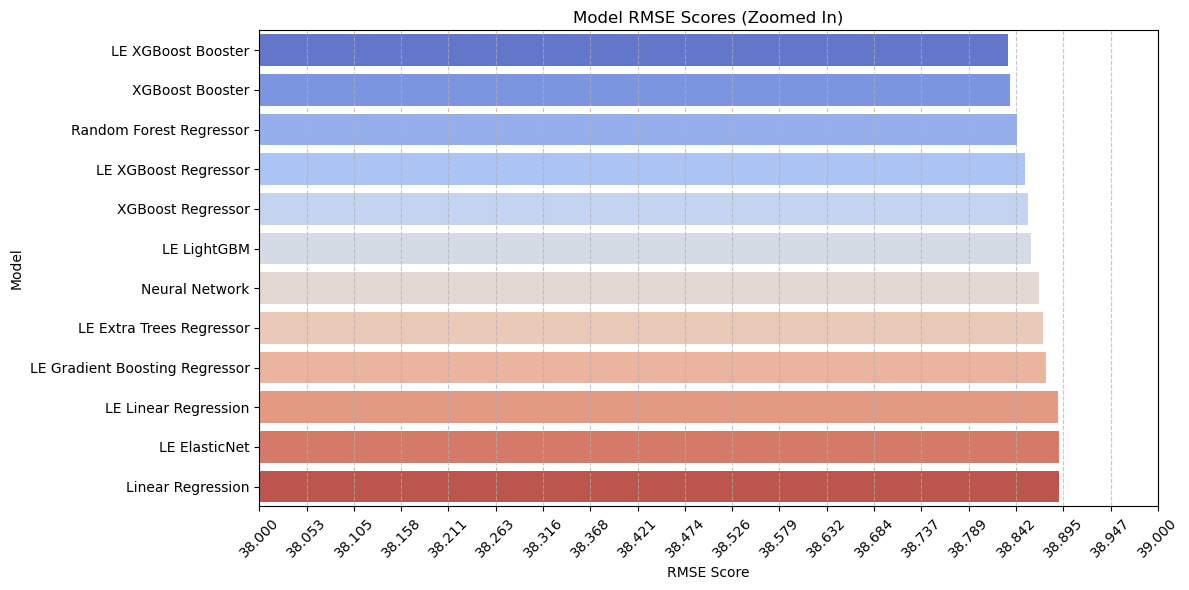

In [ ]:
import seaborn as sns
import mplcursors

# Create a dictionary of model names and their RMSE scores
model_rmse_scores = {
    "LE XGBoost Booster": le_xgb_rmse_valid,
    "LE XGBoost Regressor": le_xgbreg_rmse_valid,
    "LE Linear Regression": le_rmse_lr,
    "LE ElasticNet": en_rmse_valid,
    "LE Gradient Boosting Regressor": gbr_rmse_valid,
    "LE LightGBM": lgb_rmse_valid,
    "LE Extra Trees Regressor": et_rmse_valid,
    "XGBoost Booster": xgb_rmse_valid,
    "XGBoost Regressor": xgbreg_rmse_valid,
    "Linear Regression": rmse_lr,
    "Random Forest Regressor": rf_rmse_valid,
    "Neural Network": nn_rmse_valid
}

# Sort the models by RMSE scores
sorted_model_rmse = dict(sorted(model_rmse_scores.items(), key=lambda item: item[1]))

# Convert the sorted dictionary to a DataFrame for Seaborn
rmse_df = pd.DataFrame(list(sorted_model_rmse.items()), columns=['Model', 'RMSE'])

# Plot the RMSE scores with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df, x='RMSE', y='Model', palette='coolwarm', orient='h')
plt.xlabel('RMSE Score')
plt.ylabel('Model')
plt.title('Model RMSE Scores (Zoomed In)')
plt.xlim(38, 39)  # Set the x-axis limits to zoom in
plt.xticks(np.linspace(38, 39, 20), rotation=45)  # Add 20 bins between 38 and 39
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add tooltips for the bars
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"{sel.artist.get_label()}"))

In [81]:
# Print the best model and its RMSE score
print(f"The best model is '{best_model_name}' with a validation RMSE of {best_rmse:.3f}.")

The best model is 'LE XGBoost Booster' with a validation RMSE of 38.834.


## Conclusion

This notebook explored various machine learning models and techniques to predict the price of backpacks based on their features. The key findings and steps are summarized below:

1. **Exploratory Data Analysis (EDA)**:
    - The dataset contained a mix of categorical and numerical features, with some missing values.
    - Significant correlations were observed between certain features and the target variable (`Price`).
    - The `training_extra` dataset provided additional data, which improved model training.

2. **Data Preprocessing**:
    - Missing values in numerical columns were imputed using the median, while categorical columns were filled with "Missing".
    - Numerical features were standardized, and categorical features were one-hot encoded for most models.
    - Feature engineering was performed by combining categorical features with `Weight Capacity`.

3. **Modeling**:
    - Multiple models were trained, including Linear Regression, Random Forest, XGBoost, LightGBM, Gradient Boosting, Neural Networks, and Extra Trees.
    - Hyperparameter tuning was performed for several models using `GridSearchCV` to optimize their performance.
    - Validation RMSE was used as the primary evaluation metric to compare models.

4. **Findings**:
    - XGBoost and LightGBM consistently outperformed other models in terms of validation RMSE.
    - Neural Networks showed competitive performance but required careful tuning and longer training times.
    - Random Forest and Extra Trees provided reasonable performance but were slightly less accurate than boosting models.
    - Median imputation for numerical features was as effective as KNN imputation, while being computationally simpler.

5. **Best Model**:
    - The best-performing model was identified as `XGBoost` with label encoded features, achieving the lowest validation RMSE.

6. **Future Work**:
    - Further optimization of hyperparameters using advanced techniques like Bayesian Optimization.
    - Exploration of other ensemble methods to combine predictions from multiple models.
    - Incorporation of domain-specific knowledge to improve feature engineering.

In conclusion, this notebook demonstrated a comprehensive approach to solving a regression problem using various machine learning models and preprocessing techniques. The findings highlight the importance of data preprocessing, feature engineering, and model selection in achieving accurate predictions. The best model can now be used to make final predictions on the test dataset for submission to the competition.


In [87]:
mlflow.end_run()

🏃 View run frank_house_395trww4 at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f/runs/345009a4-7239-4194-90cf-713b87d5a36b
🧪 View experiment at: https://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/a4e67b88-5120-438c-876d-dd83e216f0f7/resourceGroups/rg-3_dayML-ws/providers/Microsoft.MachineLearningServices/workspaces/ws-azureml-mlw/#/experiments/ba909f61-b6ac-461d-95d9-8a4ccb0f387f


New Shuri Baseline Edits

**DONE**:
- one hot encoding categorcal
- median impute for numerical and missing for categorical
  - compared knnimpute vs median impute for numerical (same MAE on a simple linear model)
- verify/removed "multiplying weight capacity by 100" feature
- Center = 0 in Heatmap to highlight negative vs. positive correlation more clearly.
- check missing values meaning -> don't have domain-specific knowledge (confirm this?)
- standardized numeric features (inserted standardscaler step after imputing numeric cols, before ohe)

note: i moved your xgboost after the OHE for cohesion + updated the variable names accordingly

**TO DO**:

- Do Hyperparameter Tuning: - thought you could edit your code for this @perry
  - Instead of a single set of XGBoost parameters, do a small grid search or RandomizedSearchCV on learning_rate, max_depth, n_estimators, etc. Evaluate on validation set.
- Try even more models (Neural Networks, Random Forest)
- create final comparison table


